In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.optimize import minimize


## 2 The Factors
### 1 Analyze the factors

In [53]:
df = pd.read_excel("factor_pricing_data_monthly.xlsx", sheet_name="factors (excess returns)")
df.set_index("Date", inplace=True)
df

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
1980-01-31,0.0550,0.0188,0.0185,-0.0184,0.0189,0.0745
1980-02-29,-0.0123,-0.0162,0.0059,-0.0095,0.0292,0.0789
1980-03-31,-0.1289,-0.0697,-0.0096,0.0182,-0.0105,-0.0958
1980-04-30,0.0396,0.0105,0.0103,-0.0218,0.0034,-0.0048
1980-05-31,0.0526,0.0200,0.0038,0.0043,-0.0063,-0.0118
...,...,...,...,...,...,...
2025-04-30,-0.0084,-0.0186,-0.0340,-0.0285,-0.0267,0.0497
2025-05-31,0.0606,-0.0072,-0.0288,0.0126,0.0251,0.0221
2025-06-30,0.0486,-0.0002,-0.0160,-0.0319,0.0145,-0.0264


In [54]:
mean = df.mean(axis=0) * 12
vol = df.std(axis=0) * np.sqrt(12)
sharpe = mean / vol

result = pd.DataFrame([mean, vol, sharpe], index = ["mean", "vol", "sharpe"])
result

,MKT,SMB,HML,RMW,CMA,UMD
mean,0.087552,0.006120,0.026039,0.044047,0.028288,0.060313
vol,0.156142,0.101274,0.108835,0.082931,0.072480,0.153352
sharpe,0.560718,0.060435,0.239249,0.531132,0.390284,0.393299


## 2. Factor Analysis


**From the result above, it is clear that each factor has a positive risk premium**

**To analyze how the factors have performed, we conduct the following analysis:**

In [55]:
df_2015 = df.loc["2015":]
df_2015

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
2015-01-31,-0.0309,-0.0093,-0.0345,0.0158,-0.0164,0.0374
2015-02-28,0.0614,0.0036,-0.0179,-0.0110,-0.0175,-0.0310
2015-03-31,-0.0109,0.0308,-0.0038,0.0007,-0.0062,0.0270
2015-04-30,0.0060,-0.0301,0.0180,0.0005,-0.0062,-0.0727
2015-05-31,0.0138,0.0082,-0.0111,-0.0176,-0.0083,0.0568
...,...,...,...,...,...,...
2025-04-30,-0.0084,-0.0186,-0.0340,-0.0285,-0.0267,0.0497
2025-05-31,0.0606,-0.0072,-0.0288,0.0126,0.0251,0.0221
2025-06-30,0.0486,-0.0002,-0.0160,-0.0319,0.0145,-0.0264


In [56]:
mean = df_2015.mean(axis=0) * 12
vol = df_2015.std(axis=0) * np.sqrt(12)
sharpe = mean / vol

result = pd.DataFrame([mean, vol, sharpe], index = ["mean", "vol", "sharpe"])
result

,MKT,SMB,HML,RMW,CMA,UMD
mean,0.117872,-0.023775,-0.016303,0.040012,-0.009141,0.020119
vol,0.157356,0.103166,0.129885,0.072632,0.082072,0.137387
sharpe,0.749078,-0.230455,-0.125520,0.550896,-0.111373,0.146438


**From the result above, it is clear that some of the factors have performed worse since 2015, such as SMB , CMA and UMD, which has a lower excess return mean after 2015. While some factors performed better in recent years, like US Equities**


## 3.Correlation Matrix Across Factors

<Axes: >

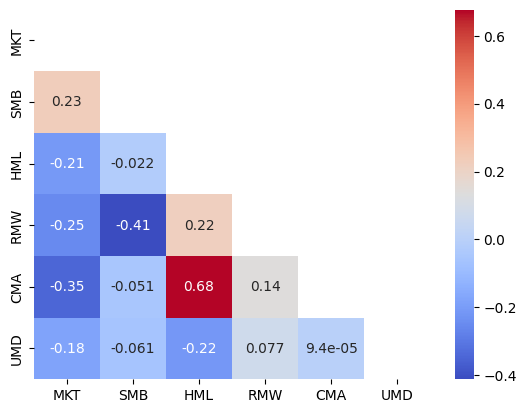

In [57]:
correlation = df.corr()

mask = np.triu(np.ones_like(correlation, dtype=bool))

sn.heatmap(correlation, mask = mask, annot=True, cmap="coolwarm")

**The construction method did succceed in keeping correlations small. I don't think HML is redundant since it is only heavily correlated with CMA, while maintaining minimal correlations with other factors**

## 4. Tangency Portfolio

In [58]:
def optimized_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    if returns.mean() @ weights < 0:
        weights = -weights

    weights = pd.Series(weights, index = returns.columns)
    weights.name = "weights"

    return weights

In [59]:
weights = optimized_weights(df, scale_cov=1)
weights_2 = np.linalg.inv(df.cov()) @ df.mean()  # also use df.mean() not mean
weights_2 = weights_2 / weights_2.sum()

result_comparison = pd.DataFrame([sharpe, mean, weights, weights_2], index = ["sharpe", "mean", "weights", "weights_my_own"])
result_comparison

,MKT,SMB,HML,RMW,CMA,UMD
sharpe,0.749078,-0.230455,-0.125520,0.550896,-0.111373,0.146438
mean,0.117872,-0.023775,-0.016303,0.040012,-0.009141,0.020119
weights,0.218650,0.066849,-0.021212,0.301829,0.321431,0.112453
weights_my_own,NaN,NaN,NaN,NaN,NaN,NaN


**Profitability seems the most important in the tangency portfolio, while the book market ratio factor seems the least important in driving revenue but rather provide a lot of diversification purposes**

In [60]:
df_adjusted = df[["MKT", "SMB", "HML","UMD"]]

mean_new = df_adjusted.mean(axis=0)

weights_new = optimized_weights(df_adjusted)


sharpe_new = mean_new / df_adjusted.std(axis=0)

result_comparison = pd.DataFrame([sharpe_new, mean_new, weights_new], index = ["sharpe", "mean", "weights"])
result_comparison


,MKT,SMB,HML,UMD
sharpe,0.161865,0.017446,0.069065,0.113536
mean,0.007296,0.000510,0.002170,0.005026
weights,0.376514,-0.051198,0.365321,0.309363


**MKT and HML has very high tangency weights now while SMB has the lowest tangency weight**

# Smart Beta and Factor Investing

This assignment refers to the HBS case: **Smart Beta Exchange-Traded-Funds and Factor Investing**.

* The case is a good introduction to important pricing factors.
* It also gives useful introduction and context to ETFs, passive vs active investing, and so-called “smart beta” funds.

# 1. READING

1. Describe how each of the factors (other than MKT) is measured.1That is, each factor is a portfolio of stocks–which stocks are included in the factor portfolio?

1. Is the factor portfolio...
    * long-only
    * long-short
    * value-weighted
    * equally-weighted

1. What steps are taken in the factor construction to try to reduce the correlation between the factors?
5. What is the point of figures 1-6?
6. How is a “smart beta” ETF different from a traditional ETF?
7. Is it possible for all investors to have exposure to the “value” factor?
8. How does factor investing differ from traditional diversification?

#### Footnote:

If you need more info in how these factor portfolios are created, see Ken French’s website, and the follow- details: 

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_mom_factor.html

***

# 2. The Factors

### Data
Use the data found in `data/factor_pricing_data.xlsx`.

Factors: Monthly excess return data for the overall equity market, $\tilde{r}^{\text{MKT}}$.

* The column header to the market factor is `MKT` rather than `MKT-RF`, but it is indeed already in excess return form.

* The sheet also contains data on five additional factors.

* All factor data is already provided as excess returns

### 1. 
Analyze the factors, similar to how you analyzed the three Fama-French factors in `Homework 4`.

You now have three additional factors, so let’s compare there univariate statistics. 

* mean
* volatility    
* Sharpe

In [61]:
df = pd.read_excel("factor_pricing_data_monthly.xlsx", sheet_name="factors (excess returns)", index_col=0)
df.index = pd.to_datetime(df.index)

sr_mean = df.mean() * 12
sr_vol = df.std() * np.sqrt(12)
sr_shp = sr_mean / sr_vol

df_sta = pd.DataFrame({"mean":sr_mean,
                        "volatility":sr_vol,
                        "sharpe": sr_shp})

df_sta

,mean,volatility,sharpe
MKT,0.087552,0.156142,0.560718
SMB,0.006120,0.101274,0.060435
HML,0.026039,0.108835,0.239249
RMW,0.044047,0.082931,0.531132
CMA,0.028288,0.072480,0.390284
UMD,0.060313,0.153352,0.393299


### 2. 

Based on the factor statistics above, answer the following.
* Does each factor have a positive risk premium (positive expected excess return)? 
* How have the factors performed since the time of the case, (2015-present)?


In [62]:
df_case = df.loc["2015-01-01":]

sr_mean_case = df_case.mean() * 12
sr_vol_case = df_case.std() * np.sqrt(12)
sr_shp_case = sr_mean_case / sr_vol_case

df_sta_case = pd.DataFrame({"mean":sr_mean_case,
                        "volatility":sr_vol_case,
                        "sharpe": sr_shp_case})

df_sta_case

,mean,volatility,sharpe
MKT,0.117872,0.157356,0.749078
SMB,-0.023775,0.103166,-0.230455
HML,-0.016303,0.129885,-0.125520
RMW,0.040012,0.072632,0.550896
CMA,-0.009141,0.082072,-0.111373
UMD,0.020119,0.137387,0.146438


Answer to Question 2:

- Yes.

- MKT, RMW, UMD have positive risk premium. Others don't.

### 3. 

Report the correlation matrix across the six factors.
* Does the construction method succeed in keeping correlations small?
* Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?

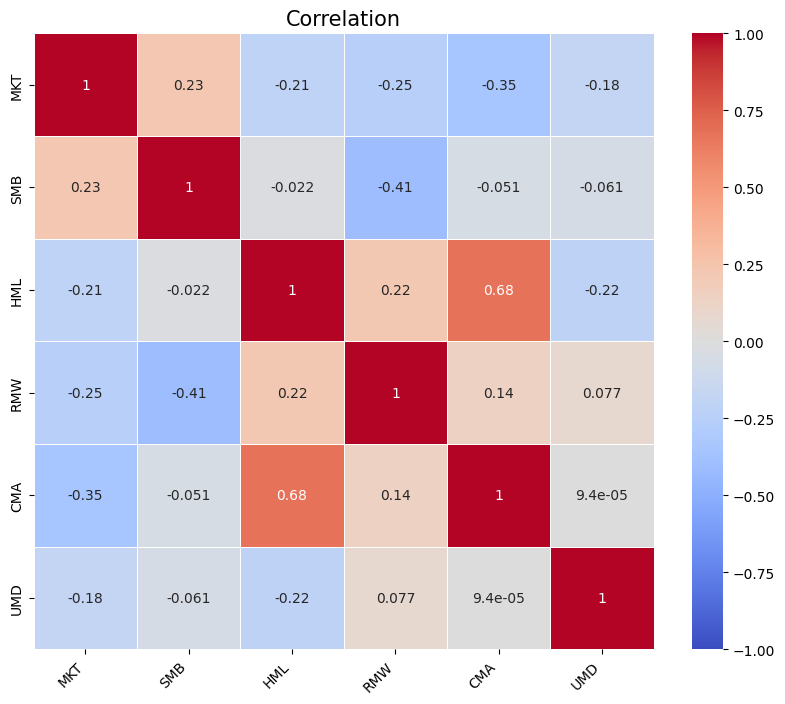

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

df_corr = df.corr()

plt.figure(figsize=(10, 8))  # 设置画布大小

# 绘制热力图（核心代码）
sns.heatmap(
    df_corr,
    annot=True,        
    cmap='coolwarm',    
    vmin=-1, vmax=1,    
    center=0,           
    linewidths=0.5,     
    # cbar_kws={'label': 'Corr'}  
)

plt.title('Correlation', fontsize=15)  
plt.xticks(rotation=45, ha='right') 
# plt.tight_layout() 

plt.show()

Answer:

- The correlations are not very big.

- Although HML has a high correlation with CMA, it has low correlation with other factors.




### 4. 

Report the tangency weights for a portfolio of these 6 factors.
* Which factors seem most important? And Least?
* Are the factors with low mean returns still useful?
* Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?

What do you conclude about the importance or unimportance of these styles?

MKT    6.550187
SMB    2.002622
HML   -0.635449
RMW    9.042041
CMA    9.629252
UMD    3.368805
Name: weights, dtype: float64


<Axes: >

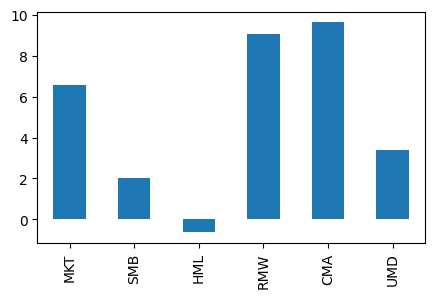

In [64]:
from scipy.optimize import minimize

# sr_mean = rets.mean()
# df_cov = rets.cov()
# rf = 0
# n_assets = rets.shape[1]

def optimized_weights(df_rets,dropna=True,scale_cov=1):
    if dropna:
        df_rets = df_rets.dropna()

    covmat_full = df_rets.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,df_rets.mean())
    # weights = weights / weights.sum()

    if df_rets.mean() @ weights < 0:
        weights = -weights

    return pd.DataFrame(weights, index=df_rets.columns, columns=['weights'])

df_weights_unbounded = optimized_weights(df)['weights']
print(df_weights_unbounded)

plt.figure(figsize=(5,3))
df_weights_unbounded.plot.bar()

Answer:

- HML seems to be the least important and CMA and PMW are most important ones.

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [66]:
df_factors = pd.read_excel('factor_pricing_data_monthly.xlsx', sheet_name='factors (excess returns)')
df_factors.set_index('Date', inplace=True)
df_test = pd.read_excel('factor_pricing_data_monthly.xlsx', sheet_name='portfolios (excess returns)')
df_test.set_index('Date', inplace=True)

In [67]:
AnnualizationFactor = 12

In [68]:
df_factors.head()

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
1980-01-31,0.0550,0.0188,0.0185,-0.0184,0.0189,0.0745
1980-02-29,-0.0123,-0.0162,0.0059,-0.0095,0.0292,0.0789
1980-03-31,-0.1289,-0.0697,-0.0096,0.0182,-0.0105,-0.0958
1980-04-30,0.0396,0.0105,0.0103,-0.0218,0.0034,-0.0048
1980-05-31,0.0526,0.0200,0.0038,0.0043,-0.0063,-0.0118


### Question 1

In [69]:
reg_dict = {}
alpha_AQR = []
model = LinearRegression()
X = df_factors[['MKT', 'HML', 'RMW', 'UMD']]
for col in df_test.columns:
    y = df_test[col]
    model.fit(X, y)
    alpha = model.intercept_.item() * AnnualizationFactor
    reg_dict[col] = (alpha, model.score(X,y))
    alpha_AQR.append(abs(alpha))
reg_dict

{'Agric': (0.011650699285749376, 0.3420744836499603),
 'Food ': (0.0015000694207832482, 0.4550642791648296),
 'Soda ': (0.015381493846173152, 0.3025437337801121),
 'Beer ': (0.009853401314914738, 0.414773181901106),
 'Smoke': (0.04110970733257899, 0.26536292831592934),
 'Toys ': (-0.033703810105509324, 0.510212934872883),
 'Fun  ': (0.03906454959762441, 0.6072125378429298),
 'Books': (-0.03670532389830129, 0.6889331824147402),
 'Hshld': (-0.012743345582406546, 0.5547117301752084),
 'Clths': (-0.022670009931975127, 0.6189681968042005),
 'Hlth ': (-0.04067722687103768, 0.44085804954081087),
 'MedEq': (0.016367917280677668, 0.5957805838064066),
 'Drugs': (0.02564695075029726, 0.4893819171211329),
 'Chems': (-0.035134538873798325, 0.7452255326428552),
 'Rubbr': (-0.004521308502526602, 0.6453147340172991),
 'Txtls': (-0.03674377137199987, 0.5470222398043796),
 'BldMt': (-0.02863197396848767, 0.752532273230015),
 'Cnstr': (-0.03531633690925022, 0.631499987539843),
 'Steel': (-0.0324237140792

In [70]:
model.coef_

array([ 1.0456675 ,  0.09872946,  0.13453947, -0.02178884])

### Question 2.

In [71]:
MAE_AQR = sum(alpha_AQR) / len(alpha_AQR)
MAE_AQR

0.024610849041637902

#### Answer 2

The MAE is not that small: .024. This would indicate that around 2.4% of the returns cannot be explained by AQR's factors.

### Question 2(2).

In [72]:
### CAPM
reg_dict = {}
alpha_CAPM = []
model = LinearRegression()
X = df_factors[['MKT']]
for col in df_test.columns:
    y = df_test[col]
    model.fit(X, y)
    alpha = model.intercept_.item() * AnnualizationFactor
    reg_dict[col] = (alpha, model.score(X,y))
    alpha_CAPM.append(abs(alpha))
reg_dict

{'Agric': (0.02371623986704579, 0.3332502451738336),
 'Food ': (0.03958754949806073, 0.3540606007098035),
 'Soda ': (0.04520498460287084, 0.2449244211819548),
 'Beer ': (0.05150934672462387, 0.32440885544918807),
 'Smoke': (0.0859621301071104, 0.18214080949290135),
 'Toys ': (-0.03519885363561513, 0.4962543693002631),
 'Fun  ': (0.011039167344629605, 0.5860708187673752),
 'Books': (-0.023611750637821182, 0.6551385634452895),
 'Hshld': (0.01651932293641418, 0.4862175096743381),
 'Clths': (-0.004743733621000883, 0.5607423298383393),
 'Hlth ': (-0.003261345630737128, 0.4057529778322091),
 'MedEq': (0.020229640470551195, 0.5855047992768456),
 'Drugs': (0.03652299398935285, 0.46662457302723925),
 'Chems': (-0.014269894705647355, 0.6845456969441337),
 'Rubbr': (0.0014125516265436344, 0.634287624497914),
 'Txtls': (-0.02425969429568863, 0.43106338969014824),
 'BldMt': (-0.002437408232968362, 0.6949234926859056),
 'Cnstr': (-0.012272319094955311, 0.6106908475983202),
 'Steel': (-0.057539297257

In [73]:
model.coef_

array([1.01728733])

In [74]:
MAE_CAPM = sum(alpha_CAPM) / len(alpha_CAPM)
MAE_CAPM

0.020970330677320567

In [75]:
### FF3
reg_dict = {}
alpha_FF3 = []
model = LinearRegression()
X = df_factors[['MKT', 'SMB', 'HML']]
for col in df_test.columns:
    y = df_test[col]
    model.fit(X, y)
    alpha = model.intercept_.item() * AnnualizationFactor
    reg_dict[col] = (alpha, model.score(X,y))
    alpha_FF3.append(abs(alpha))
reg_dict

{'Agric': (0.01995200437321585, 0.3572836122155515),
 'Food ': (0.028691716101608693, 0.4041166791829469),
 'Soda ': (0.03189881722090511, 0.27344203306332515),
 'Beer ': (0.0457795421759657, 0.3518066920608397),
 'Smoke': (0.0692872855448976, 0.2311577790054432),
 'Toys ': (-0.03494930530612349, 0.5304880295156791),
 'Fun  ': (0.012064848248240487, 0.5952044273977266),
 'Books': (-0.03430801050299502, 0.6911098257421664),
 'Hshld': (0.01244466764563288, 0.5043381475569546),
 'Clths': (-0.010456757554471278, 0.573900970962221),
 'Hlth ': (-0.008172680681034342, 0.43507739571582515),
 'MedEq': (0.02636069006321523, 0.5955129058049629),
 'Drugs': (0.03986423731047998, 0.49954180649422986),
 'Chems': (-0.02920645793155561, 0.728360293593795),
 'Rubbr': (-0.001024772137122102, 0.6837101926164264),
 'Txtls': (-0.04767168126465273, 0.5862542859087594),
 'BldMt': (-0.016889968876074885, 0.7492266337531879),
 'Cnstr': (-0.021262072256441708, 0.6552422257912154),
 'Steel': (-0.06714147807858256

In [76]:
model.coef_

array([1.03480454, 0.00374271, 0.12467438])

In [77]:
MAE_FF3 = sum(alpha_FF3) / len(alpha_FF3)
MAE_FF3

0.024358059122629356

In [78]:
### FF5
reg_dict = {}
alpha_FF5 = []
model = LinearRegression()
X = df_factors[['MKT', 'SMB', 'HML', 'RMW', 'CMA']]
for col in df_test.columns:
    y = df_test[col]
    model.fit(X, y)
    alpha = model.intercept_.item() * AnnualizationFactor
    reg_dict[col] = (alpha, model.score(X,y))
    alpha_FF5.append(abs(alpha))
reg_dict

{'Agric': (0.0071693167416732075, 0.36189680032589133),
 'Food ': (-0.006417266962200737, 0.4781017031550969),
 'Soda ': (-0.00169553164325012, 0.30640278207789895),
 'Beer ': (0.00410416746808738, 0.4335645691889225),
 'Smoke': (0.020506595340591675, 0.2943616069680609),
 'Toys ': (-0.06288432301767417, 0.5509376996638676),
 'Fun  ': (0.024145721897980386, 0.5995113841202688),
 'Books': (-0.0488426929633155, 0.7021872588759339),
 'Hshld': (-0.02451722563738662, 0.5818837295084006),
 'Clths': (-0.04498676402573174, 0.629067740349132),
 'Hlth ': (-0.04897420039863376, 0.4905153784930124),
 'MedEq': (0.011556076496517728, 0.6045491991681019),
 'Drugs': (0.022556553362292394, 0.5189845285559775),
 'Chems': (-0.050796293966824994, 0.7461204328576003),
 'Rubbr': (-0.024183717995231006, 0.704417702705457),
 'Txtls': (-0.07698103091313799, 0.618309634596574),
 'BldMt': (-0.04356435658660536, 0.7800253686787557),
 'Cnstr': (-0.0440624767933959, 0.6727532140397003),
 'Steel': (-0.05847244390128

In [79]:
model.coef_

array([1.05357576, 0.05303602, 0.06876469, 0.16092121, 0.07900827])

In [80]:
MAE_FF5 = sum(alpha_FF5) / len(alpha_FF5)
MAE_FF5

0.03137208981381941

In [81]:
mae_table = pd.DataFrame({
    "Model": ["CAPM", "FF3", "FF5", "AQR"],
    "MAE": [MAE_CAPM, MAE_FF3, MAE_FF5, MAE_AQR]
})

mae_table.set_index("Model", inplace=True)
mae_table


,MAE
Model,
CAPM,0.020970
FF3,0.024358
FF5,0.031372
AQR,0.024611


### Question 2(2) Answers

CAPM appears to have the smallest MAE out of the 4 models & has the best fit by that metric.

### Question 3: Factor Importance and Momentum Factor Analysis


#### Answer to Question 3

The market factor is immediately important. The robustness factor seems like the next most important factor. Momentum does not appear to be a significant factor because it's weighting is much less in the AQR model.

In [82]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [83]:
df_test = pd.read_excel('factor_pricing_data_monthly.xlsx', sheet_name='portfolios (excess returns)')
df_test.set_index('Date', inplace=True)
df_test.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,-0.0073,0.0285,0.0084,0.1009,-0.0143,0.0995,0.0348,0.0323,0.0048,0.0059,...,0.0158,0.0851,0.0466,-0.0125,0.0430,-0.0284,0.0254,0.0770,0.0306,0.0666
1980-02-29,0.0125,-0.0609,-0.0967,-0.0323,-0.0575,-0.0316,-0.0492,-0.0803,-0.0556,-0.0169,...,-0.0083,-0.0543,-0.0345,-0.0641,-0.0653,-0.0824,-0.0960,-0.0352,-0.0283,-0.0273
1980-03-31,-0.2220,-0.1119,-0.0158,-0.1535,-0.0188,-0.1272,-0.0827,-0.1238,-0.0567,-0.0670,...,-0.0819,-0.1512,-0.1602,-0.0905,-0.1450,-0.0559,-0.0877,-0.2449,-0.1261,-0.1737
1980-04-30,0.0449,0.0767,0.0232,0.0289,0.0830,-0.0529,0.0785,0.0154,0.0305,0.0115,...,0.0422,-0.0102,0.0268,0.0355,0.0539,0.0736,0.0528,0.0964,0.0458,0.0784
1980-05-31,0.0635,0.0797,0.0458,0.0866,0.0822,0.0510,0.0325,0.0888,0.0560,0.0098,...,0.0564,0.1065,0.1142,0.0877,0.1104,0.0570,0.0560,0.0889,0.0846,0.0663


In [84]:
df_factors = pd.read_excel('factor_pricing_data_monthly.xlsx', sheet_name='factors (excess returns)')
df_factors.set_index('Date', inplace=True)
df_factors.head()

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
1980-01-31,0.0550,0.0188,0.0185,-0.0184,0.0189,0.0745
1980-02-29,-0.0123,-0.0162,0.0059,-0.0095,0.0292,0.0789
1980-03-31,-0.1289,-0.0697,-0.0096,0.0182,-0.0105,-0.0958
1980-04-30,0.0396,0.0105,0.0103,-0.0218,0.0034,-0.0048
1980-05-31,0.0526,0.0200,0.0038,0.0043,-0.0063,-0.0118


4.
This does not matter for pricing, but report the average (across $n$ estimations) of the time-series regression r-squared statistics.
- Do this for each of the three models you tested. (NOTE: I did 4 — CAPM, FF3, FF5, and AQR)
- Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?

In [85]:
models = {
    'CAPM': ['MKT'],
    'FF3':  ['MKT', 'SMB', 'HML'],
    'FF5':  ['MKT', 'SMB', 'HML', 'RMW', 'CMA'],
    'AQR':  ['MKT', 'HML', 'RMW', 'UMD']
}

avg_r2 = {}
for name, facs in models.items():
    r2s = []
    for asset in df_test.columns:
        y = df_test[asset].dropna()
        X = sm.add_constant(df_factors.loc[y.index, facs])
        model = sm.OLS(y, X, missing='drop').fit()
        r2s.append(model.rsquared)
    avg_r2[name] = np.mean(r2s)

pd.Series(avg_r2)

CAPM    0.522622
FF3     0.567874
FF5     0.591768
AQR     0.571935
dtype: float64

These R-squared values are not particularly high (all in the range of roughly $0.52$ to $0.59$). In other words, on average, the factor models explain a moderate amount of the variation we see in our sample of portfolio returns. So, these factors would not be particularly good for a linear factor decomposition of the assets because while they provide a reasonable fit, they are insufficient in explaining a significant amount of the variation seen in portfolio returns.

5.
We tested three models using the time-series tests (focusing on the time-series alphas.) Re-test these models, but this time use the cross-sectional test.
- Report the time-series premia of the factors (just their sample averages) and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?
- Report the MAE of the cross-sectional regression residuals for each of the four models. How do they compare to the MAE of the time-series alphas?

In [86]:
def regression(df_test, df_factors, facs):
    betas = []
    for asset in df_test.columns:
        y = df_test[asset].dropna()
        X = sm.add_constant(df_factors.loc[y.index, facs])
        model = sm.OLS(y, X, missing='drop').fit()
        betas.append(model.params[1:])
    return pd.DataFrame(betas, index=df_test.columns, columns=facs)

def cross_sectional(df_test, facs, betas):
    lambdas = []
    abs_errors = []
    for t in df_test.index:
        r_t = df_test.loc[t].dropna()
        B_t = betas.loc[r_t.index, facs]
        lam = np.linalg.lstsq(B_t, r_t, rcond=None)[0]
        lambdas.append(lam)
        abs_errors.extend(np.abs(r_t - B_t @ lam))
    lambdas = pd.DataFrame(lambdas, columns=facs, index=df_test.index)
    return lambdas.mean() * 12, np.mean(abs_errors) * 12

time_series_premia = {}
cross_section_premia = {}
mae_resids = {}

for name, facs in models.items():
    cs_prem, mae_cs = cross_sectional(df_test, facs, regression(df_test, df_factors, facs))
    time_series_premia[name] = df_factors[facs].mean() * 12
    cross_section_premia[name] = cs_prem
    mae_resids[name] = mae_cs

rows = []
for model, facs in models.items():
    for f in facs:
        rows.append({
            'Model': model,
            'Factor': f,
            'Time-Series Premia (Ann)': time_series_premia[model][f],
            'Cross-Sectional Premia (Ann)': cross_section_premia[model][f]
        })

display(pd.DataFrame(rows).set_index('Model'))


,Factor,Time-Series Premia (Ann),Cross-Sectional Premia (Ann)
Model,,,
CAPM,MKT,0.087552,0.085638
FF3,MKT,0.087552,0.101587
FF3,SMB,0.006120,-0.062027
FF3,HML,0.026039,-0.015950
FF5,MKT,0.087552,0.096517
FF5,SMB,0.006120,-0.053949
FF5,HML,0.026039,-0.029889
FF5,RMW,0.044047,0.028818
FF5,CMA,0.028288,-0.008620


These results show that the time-series premia (factor means) and the cross-sectionally estimated premia are broadly similar in magnitude for the main market factor, but they diverge more for the size (SMB) and value (HML) factors.

More specifically, the premia are similar across all four models for the MKT factor. However, for the FF3 model, the SMB and HML time-series premia are positive, while the cross-sectional premia are negative. Further, the cross-sectional premium for the SMB factor is larger in magnitude than the time-series premium by a factor of 10. The premia are roughly similar in magnitude for the HML factor.

The FF5 model shows similar trends: the SMB and HML factors have positive premia for time-series and negative for cross-sectional; we also see the same difference in magnitude for the SMB factor. The RMW factor is similar for time-series and cross-sectional in both magnitude and direction. The CMA factor is differs significantly in both magnitude and direction. For time-series, we see a relatively large (in magnitude) positive premium, while for cross-sectional, we see a relatively small (in magnitude) negative premium.

For the AQR 4F model, the relationship between the HML factor premia is similar to the FF3 and FF5 models: roughly the same in magnitude, with the time-series being positive and the cross-sectional being negative. However, the premia for RMW and UMD factors is similar in both magnitude and direction for time-series and cross-sectional.

In [87]:
display(pd.DataFrame({'MAE of Residuals (Cross-Sectional)': mae_resids}))

,MAE of Residuals (Cross-Sectional)
CAPM,0.386441
FF3,0.356903
FF5,0.335070
AQR,0.346618


The MAEs of residuals in the cross-sectional regressions (roughly $0.33$ – $0.38$) are larger than the MAEs of time-series alphas. So, the time-series fits within each portfolio are good (small MAEs), but the factor models are not as good at explaining differences in average returns across portfolios. In other words, the factor models do not have a lot of power in cross-sectional pricing, and we see a significant amount of unexplained error (i.e., residuals) in trying to fit the factor models to expected returns.